# L-DED Audiovisual Fusion 

Author: Chen Lequn.
Created on 01 Feb 2023.

- Material： Maraging Steel 300
- Process: Robotic Llser-directed energy deposition
- Experiment number (single bead wall samples): 21-26
- Recorded data: position, veolocity, coaxial melt pool images, acoustic data
- Defect generated: keyhole pores, cracks, defect-free

### Notebook 2: benchmarking on coaxial vision dataset

- Performances for various deep learning models (VGG, GoogleNet, ResNet, LeNet, etc.) are evaluated and benchmarked on the coaxial melt pool image dataset.
- Best performance will guide subsequent multimodal fusion network development.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler

import os
import argparse
from torch.utils.data import Subset
import pandas as pd
import numpy as np

# Scikit learn
#from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle, resample, class_weight
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

from vision_models import * 
from multimodaldataset import MultimodalDataset, LDEDAudioDataset, LDEDVisionDataset
from utils import *
from train_utils import train_single_epoch, test_single_epoch, training_loop

## plot
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
# plt.rcParams["font.family"] = "serif"
# plt.rcParams["font.serif"] = "Times New Roman"
%matplotlib inline
import seaborn as sns

# Multimodal_dataset_PATH = os.path.join("C:\\Users\\Asus\\OneDrive_Chen1470\\OneDrive - Nanyang Technological University\\Dataset\\Multimodal_AM_monitoring\\LDED_Acoustic_Visual_Dataset")
# Multimodal_dataset_PATH = os.path.join("/home/chenlequn/Dataset/LDED_acoustic_visual_monitoring_dataset")
# Image_path = os.path.join(Multimodal_dataset_PATH,'Video', 'segmented',  'images')
# Audio_raw_seg_PATH = os.path.join(Multimodal_dataset_PATH, 'Video', 'segmented', 'raw_audio')
# Audio_equalized_seg_PATH = os.path.join(Multimodal_dataset_PATH, 'Video', 'segmented', 'equalized_audio')
# Audio_bandpassed_seg_PATH = os.path.join(Multimodal_dataset_PATH, 'Video', 'segmented', 'bandpassed_audio')
# Audio_denoised_seg_PATH = os.path.join(Multimodal_dataset_PATH,'Video', 'segmented',  'denoised_audio')

# AUDIO_DIR = Audio_denoised_seg_PATH
# VISON_DIR = Image_path

# torch.manual_seed(0)

# ANNOTATIONS_FILE = os.path.join(Multimodal_dataset_PATH, 'Video', 'segmented', "visual_acoustic_dataset_annotations_v2.csv")

In [2]:
def get_sample_directories(base_path, sample_numbers):
    sample_directories = []
    for sample_number in sample_numbers:
        sample_directories.append(os.path.join(base_path, f'segmented_25Hz/{sample_number}'))
    return sample_directories

Multimodal_dataset_PATH = "/home/chenlequn/Dataset/LDED_acoustic_visual_monitoring_dataset"
samples = [21, 22, 23, 26]
sample_directories = get_sample_directories(Multimodal_dataset_PATH, samples)

# Get lists of image and audio directories for each sample
image_directories = [os.path.join(sample_dir, 'images') for sample_dir in sample_directories]
audio_directories = [os.path.join(sample_dir, 'denoised_audio') for sample_dir in sample_directories]

In [3]:
classes = ('Laser-off', 'Defect-free', 'Defective')
# classes = ('Laser-off', 'Defect-free', 'Cracks', "Keyhole pores")
SAMPLE_RATE = 44100
LEARNING_RATE = 0.00001
BATCH_SIZE = 32
EPOCHS = 10

### Utils functions

In [4]:
PROJECT_ROOT_DIR = "../"
IMAGE_PATH = os.path.join(PROJECT_ROOT_DIR, "result_images", 'train_visual')
os.makedirs(IMAGE_PATH, exist_ok=True)

## function for automatically save the diagram/graph into the folder 
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGE_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2.50

### Use GPU if possible

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device}")

Using cuda


### Annotation file

- Vision acoustic spatio-temporal registration has been done in our previous work. 
- Each frame (timestamp) corresponds to a robot TCP position.
- The duration for each frame is 0.033 seconds (sampling freqeuncy 30 Hz.)

In [6]:
# Combine all annotation files into one DataFrame
all_annotation_dfs = []
for sample_dir, sample_number in zip(sample_directories, samples):
    annotation_file = os.path.join(sample_dir, f'annotations_{sample_number}.csv')  # Update the file name
    annotation_df = pd.read_csv(annotation_file)
    all_annotation_dfs.append(annotation_df)
combined_annotation_df = pd.concat(all_annotation_dfs)

combined_annotation_df = combined_annotation_df.dropna(subset=['name'])
combined_annotation_df

,sample index,audio_file_name,image_file_name,name,class_ID,class_name_v2,class_ID_2,Layer number,Sample number,class_ID_v2,region name
0,1,sample_21_1.wav,sample_21_1.jpg,Laser-off,0.0,Laser-off,0.0,1.0,21,NaN,NaN
1,2,sample_21_2.wav,sample_21_2.jpg,Crack,2.0,Defective,2.0,1.0,21,NaN,NaN
2,3,sample_21_3.wav,sample_21_3.jpg,Crack,2.0,Defective,2.0,1.0,21,NaN,NaN
3,4,sample_21_4.wav,sample_21_4.jpg,Crack,2.0,Defective,2.0,1.0,21,NaN,NaN
4,5,sample_21_5.wav,sample_21_5.jpg,Defect-free,1.0,Defect-free,1.0,1.0,21,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
10981,10982,sample_26_10982.wav,sample_26_10982.jpg,Laser-off,0.0,Laser-off,0.0,50.0,26,NaN,NaN
10982,10983,sample_26_10983.wav,sample_26_10983.jpg,Laser-off,0.0,Laser-off,0.0,50.0,26,NaN,NaN
10983,10984,sample_26_10984.wav,sample_26_10984.jpg,Laser-off,0.0,Laser-off,0.0,50.0,26,NaN,NaN
10984,10985,sample_26_10985.wav,sample_26_10985.jpg,Laser-off,0.0,Laser-off,0.0,50.0,26,NaN,NaN


In [7]:
# Get the labels and count the number of samples for each class
labels = combined_annotation_df['name'].values
label_counts = np.unique(labels, return_counts=True)[1]
print (label_counts)

[ 1431  9056  4841 12520]


### Basline accuracy
The baseline accuracy in this multi-class classificiation problem is **43%**, which is the accuracy of trivially predicting the most-frequent class (classify to the largest class– in other words).

In [8]:
### Get the percentage distribution of each category
round(combined_annotation_df.groupby('name')["name"].count()/combined_annotation_df.shape[0]*100, 1)

name
Crack             5.1
Defect-free      32.5
Keyhole pores    17.4
Laser-off        45.0
Name: name, dtype: float64

Saving figure dataset


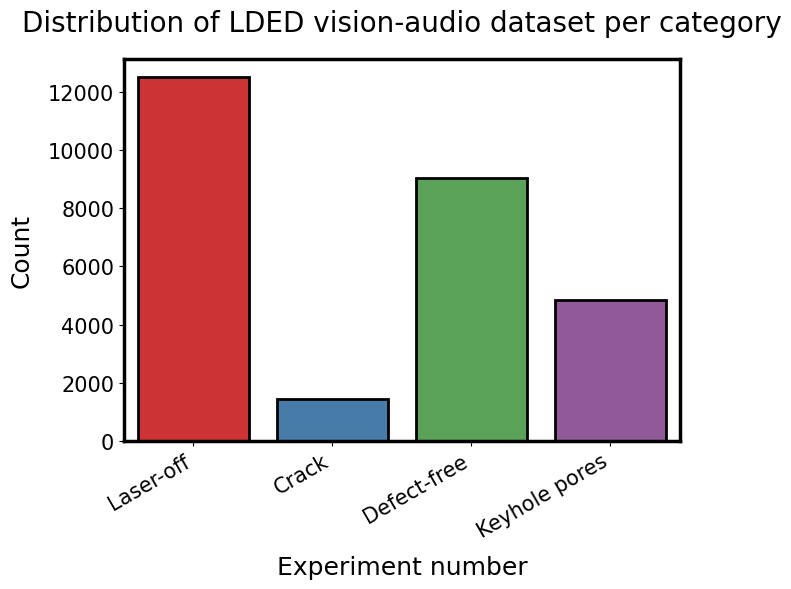

In [9]:
# sns.set(style="darkgrid")
plt.figure(figsize = (7,6))


ax = sns.countplot(x='name', data = combined_annotation_df, palette="Set1", linewidth=2,
                   edgecolor='k'); #palette='mako' 'Set2'
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right")
# ax = sns.countplot(y='label', data = df_dataset_denoised, palette="Set2");


ax.set_title('Distribution of LDED vision-audio dataset per category', fontsize = 20, pad=20);
ax.set_xlabel("Experiment number",fontsize=18, labelpad=10)
ax.set_ylabel("Count",fontsize=18, labelpad=10)
ax.tick_params(labelsize=15)

save_fig("dataset")

## Preparing Dataset and DataLoader

In [10]:
#------ transformation------
train_transforms=transforms.Compose([
    torchvision.transforms.Resize((32,32)), # original image size: (640,480)
    transforms.RandomHorizontalFlip(),  # data augmentation
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=90),
    transforms.ToTensor(),
    transforms.Normalize(mean=[63.66424300065244], std=[71.51866534828666]),
])

val_transforms=transforms.Compose([
    torchvision.transforms.Resize((32,32)), # original image size: (640,480)
    transforms.ToTensor(),
    transforms.Normalize(mean=[63.66424300065244], std=[71.51866534828666]),
])

In [11]:
#------ data loader------
# create the dataset for all samples
visiondataset = LDEDVisionDataset(combined_annotation_df,
                                  image_directories,
                                  samples,
                                  train_transforms,
                                  device)
print ("length of the total dataset:" + str(len(visiondataset)))

length of the total dataset:27848


### Dealing with Imbalanced dataset: stratified sampling

- Split the data into train, validation, and test set (or only train/val set, depending on the data volume)
- Train and Val are used for hyperparameter tuning
- Train set will go through data augmentation

In [12]:
# Split the data into train and validation datasets
# train_annotations, val_annotations = train_test_split(annotations_df, test_size=0.2)
# create the StratifiedShuffleSplit object
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

# split the indices of annotations into train and test sets
train_indices, test_indices = next(sss.split(combined_annotation_df, labels))

# split the data into train and test sets
train_annotations = combined_annotation_df.iloc[train_indices, :]
test_annotations = combined_annotation_df.iloc[test_indices, :]

# Create the train and validation datasets
train_dataset = LDEDVisionDataset(combined_annotation_df,
                                  image_directories,
                                  samples,
                                  train_transforms,
                                  device)

val_dataset = LDEDVisionDataset(combined_annotation_df,
                                image_directories,
                                samples,
                                val_transforms,
                                device)

In [13]:
# sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

# # split the indices of annotations into train, validation and test sets
# train_indices, test_val_indices = next(sss.split(annotations_df, labels))

# # Use another StratifiedShuffleSplit to split the test_val_indices into test and validation sets
# val_size = 0.5 # set the validation size
# sss2 = StratifiedShuffleSplit(n_splits=1, test_size=val_size, random_state=0)
# val_indices, test_indices = next(sss2.split(annotations_df.iloc[test_val_indices], labels[test_val_indices]))

# # split the data into train, validation, and test sets
# train_annotations = annotations_df.iloc[train_indices, :]
# val_annotations = annotations_df.iloc[val_indices, :]
# test_annotations = annotations_df.iloc[test_indices, :]

# # Create the train, validation and test datasets
# train_dataset = LDEDVisionDataset(train_annotations,
#                                   image_path = VISON_DIR,
#                                   image_transformation=train_transforms,
#                                   device=device)

# val_dataset = LDEDVisionDataset(val_annotations,
#                                 image_path=VISON_DIR,
#                                 image_transformation=val_transforms,
#                                 device=device)

# test_dataset = LDEDVisionDataset(test_annotations,
#                                  image_path=VISON_DIR,
#                                  image_transformation=val_transforms,
#                                  device=device)

### Create DataLoader using the dataset

In [14]:
# # Create train and val dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=6)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=6)
# test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=6)

print("length of the train dataset:" +  str(len(train_dataloader.dataset)))
print("length of the val dataset:" +  str(len(val_dataloader.dataset)))
# print("length of the test dataset:" +  str(len(test_dataloader.dataset)))

length of the train dataset:27848
length of the val dataset:27848


## Training the model

In [15]:
resume = False
start_epoch = 0
best_acc = 0


In [16]:
# -----Model---------------
print('==> Building model..')
net = VGG('VGG19')
# net = LeNet() 
# net = ResNet18()
# net = PreActResNet18()
# net = GoogLeNet()
# net = DenseNet121()
# net = ResNeXt29_2x64d()
# net = MobileNet()
# net = MobileNetV2()
# net = DPN92()
# net = ShuffleNetG2()
# net = SENet18()
# net = ShuffleNetV2(1)
# net = EfficientNetB0()
# net = RegNetX_200MF()
# net = SimpleDLA()
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True
    print ("--- Using CUDA ---")

if resume:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load('./checkpoint/ckpt.pth')
    net.load_state_dict(checkpoint['net'])
    best_acc = checkpoint['acc']
    start_epoch = checkpoint['epoch']

loss_fn = nn.CrossEntropyLoss()
# Note: weight_decay in pytorch is L2 regularization
# optimizer = optim.SGD(net.parameters(), lr=LEARNING_RATE,
#                     momentum=0.9, weight_decay=5e-4)
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)


# for epoch in range(start_epoch, start_epoch+EPOCHS):
#     train_single_epoch(net, epoch, train_dataloader, loss_fn, optimizer, device)
#     test_single_epoch(net, epoch, val_dataloader, loss_fn, device)
#     scheduler.step()

# model, optimizer, _ = training_loop(net, loss_fn, optimizer, train_dataloader, val_dataloader, EPOCHS, scheduler, device)
model, optimizer, (train_losses, valid_losses, train_accuracy, valid_accuracy) = training_loop(net, loss_fn, optimizer, train_dataloader, 
                                                                                               val_dataloader, EPOCHS, scheduler, device)

==> Building model..
--- Using CUDA ---

Epoch: 0


Epoch 0:   0%|               | 0/871 [01:02<?, ?it/s, loss=0.102, accuracy=96.4]


14:59:15 --- Epoch: 0	Train loss: 0.1838	Valid loss: 0.0032	Train accuracy: 92.18	Valid accuracy: 96.35

Epoch: 1


Epoch 1:   0%|               | 0/871 [01:03<?, ?it/s, loss=0.114, accuracy=95.2]


15:01:20 --- Epoch: 1	Train loss: 0.1320	Valid loss: 0.0036	Train accuracy: 94.68	Valid accuracy: 95.23

Epoch: 2


Epoch 2:   0%|                 | 0/871 [00:53<?, ?it/s, loss=0.174, accuracy=92]


15:03:00 --- Epoch: 2	Train loss: 0.1240	Valid loss: 0.0055	Train accuracy: 94.93	Valid accuracy: 92.04

Epoch: 3


Epoch 3:   0%|               | 0/871 [00:53<?, ?it/s, loss=0.082, accuracy=96.7]


15:04:40 --- Epoch: 3	Train loss: 0.1153	Valid loss: 0.0026	Train accuracy: 95.34	Valid accuracy: 96.74

Epoch: 4


Epoch 4:   0%|              | 0/871 [00:53<?, ?it/s, loss=0.0846, accuracy=96.8]


15:06:19 --- Epoch: 4	Train loss: 0.1132	Valid loss: 0.0026	Train accuracy: 95.49	Valid accuracy: 96.80

Epoch: 5


Epoch 5:   0%|               | 0/871 [00:51<?, ?it/s, loss=0.105, accuracy=95.3]


15:07:57 --- Epoch: 5	Train loss: 0.1090	Valid loss: 0.0033	Train accuracy: 95.64	Valid accuracy: 95.34

Epoch: 6


Epoch 6:   0%|                | 0/871 [00:47<?, ?it/s, loss=0.09, accuracy=96.9]


15:09:32 --- Epoch: 6	Train loss: 0.1108	Valid loss: 0.0028	Train accuracy: 95.59	Valid accuracy: 96.88

Epoch: 7


Epoch 7:   0%|              | 0/871 [00:45<?, ?it/s, loss=0.0855, accuracy=96.7]


15:11:05 --- Epoch: 7	Train loss: 0.1055	Valid loss: 0.0027	Train accuracy: 95.80	Valid accuracy: 96.69

Epoch: 8


Epoch 8:   0%|              | 0/871 [00:46<?, ?it/s, loss=0.0834, accuracy=96.8]


15:12:39 --- Epoch: 8	Train loss: 0.1047	Valid loss: 0.0026	Train accuracy: 95.86	Valid accuracy: 96.84

Epoch: 9


Epoch 9:   0%|              | 0/871 [00:42<?, ?it/s, loss=0.0881, accuracy=96.5]

15:14:12 --- Epoch: 9	Train loss: 0.1034	Valid loss: 0.0028	Train accuracy: 95.93	Valid accuracy: 96.51


In [17]:
valid_accuracy

[96.35162309681127,
 95.23125538638322,
 92.03892559609308,
 96.7394426888825,
 96.80048836541224,
 95.33539212869864,
 96.88307957483482,
 96.6855788566504,
 96.83639758690032,
 96.50962367135881]

Saving figure train_lost_curve_visual


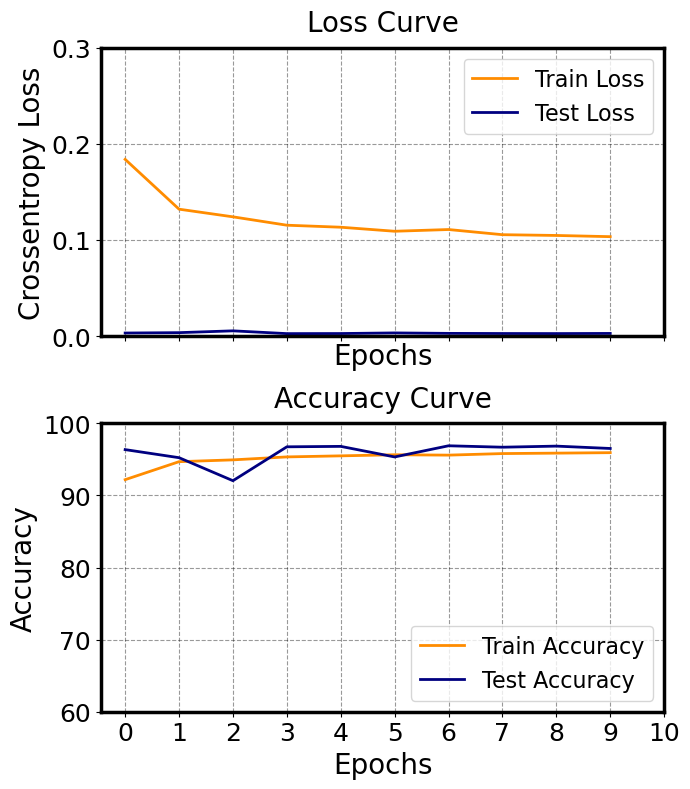

In [18]:
loss_acc_plot(train_losses, valid_losses, train_accuracy, valid_accuracy, 10, "Initial Training",
              interval=1, yloss_limit1=0, yloss_limit2=0.30, yacc_limit1=60, yacc_limit2=100)

save_fig ("train_lost_curve_visual")

In [19]:
get_accuracy(model, val_dataloader, device)

0.965096236713588

Test Accuracy (cross-validation) for MFCC-CNN = 0.96510 ± 0.00168
micro-averaging AUC for MFCC-CNN = 0.99615 ± 0.00000
Saving figure ROC_curve (vision-based)


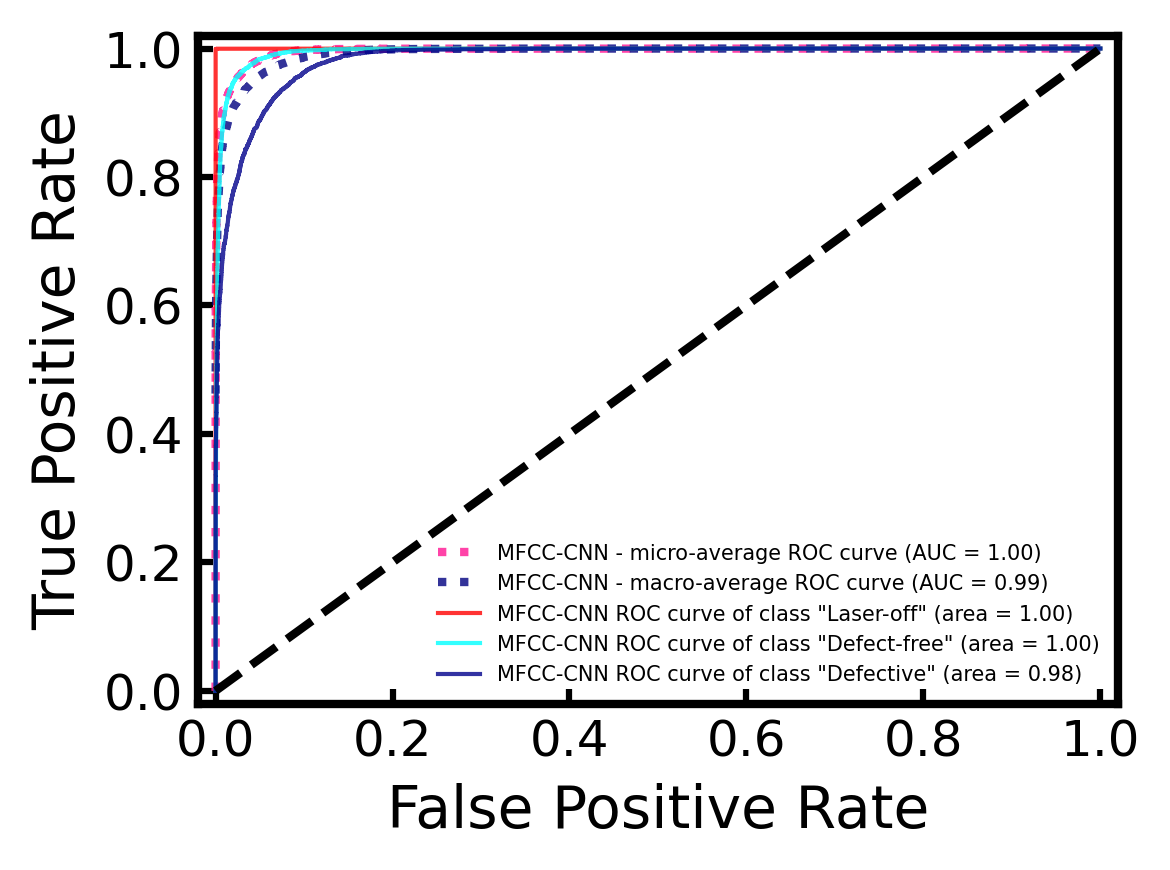

In [20]:
test_accuracy_mean, test_accuracy_std, auc_mean, auc_std = model_evaluation(model, val_dataloader, classes, device, classifier_name = "MFCC-CNN", 
                                                                            signal_type = "denoised", seed=0)

save_fig ("ROC_curve (vision-based)")

In [21]:
yt, yp = class_report(model, val_dataloader, device, classes)

              precision    recall  f1-score   support

 Defect-free     0.9313    0.9639    0.9473      9056
   Defective     0.9486    0.8976    0.9224      6272
   Laser-off     0.9982    0.9998    0.9990     12520

    accuracy                         0.9651     27848
   macro avg     0.9594    0.9538    0.9562     27848
weighted avg     0.9653    0.9651    0.9649     27848



[[ 8729   304    23]
 [  642  5630     0]
 [    2     1 12517]]
Saving figure confusion_matrix(vision_based)


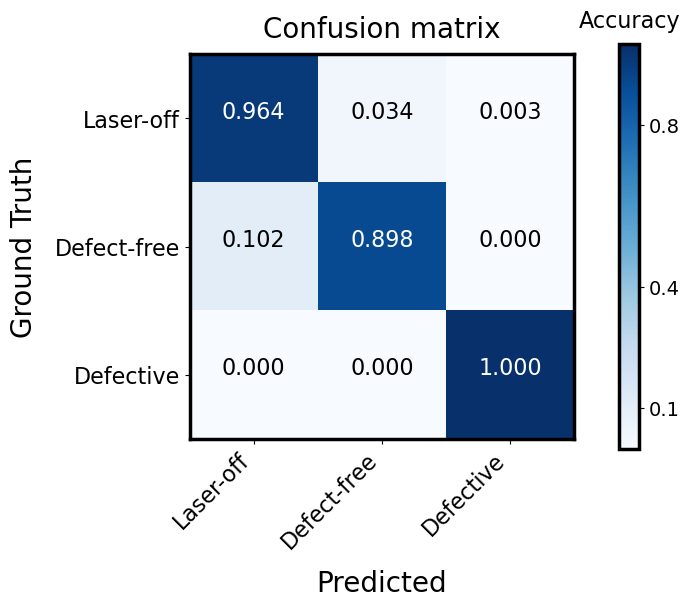

In [22]:
conf_matrix(yt, yp, classes)
save_fig("confusion_matrix(vision_based)")